In [2]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy as np
import pandas as pd
pd.set_option('max_rows', 6)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
# import cmocean.cm as cmo
import csv
import statsmodels.api as sm
from scipy import stats

# mpl.rcParams['mathtext.fontset'] = 'cm'
# mpl.rcParams['mathtext.rm'] = 'serif'

x = "Year CE"
n = r'$\mathrm{\delta}^{15}$N ['u"\u2030]"
c = r'$\mathrm{\delta}^{13}$C ['u"\u2030]"
deg = u'SST [\u00B0C]'

# Import data
path1 = '~/Documents/GitHub/data/schiff_bulk_years_07-05-2020.csv'
df = pd.read_csv(path1, comment = '#')
df.rename(columns={"d15n.vs.air": "d15n", "d13c.vs.vpdb": "d13c", "linear.ad" : "yrAD", 
                   "coral.id" : "coral", "sample.no." : "sample",
                  "secondary.ad" : "yrAD2", "distance..mm." : "distance"}, inplace = True)

# Round yrAD column to make things easier
df.yrAD = df.yrAD.round(0)

# df_jack4684 = df[df.coral == 'jack-4684-bc-unk']
# df_jack4686t1 = df[df.coral == 'jack-4686-bc-d1-t1']

df_stet = df[df.coral == 'stet-4904-bc1-d2']
df_jack4907 = df[df.coral == 'jack-4907-bc1-d3']
df_jack_usgs = df[df.coral == 'jack-4907-bc1-d1']
df_sav = df[df.coral == 'sav-4902-bc1-unk']
df_jack4684 = df[df.coral == 'jack-4684-bc-unk']
df_jack4686 = df[df.coral == 'jack-4686-bc1-d1-t1']
df_jack4686_mill = df[df.coral == 'jack-4686-bc-d1-t1']

# Binning time series
This uses a binning function from the Python library Pyleoclim, which is being developed for paleoclimate analysis.

In [4]:
# Using a binning function from Python package Pyleoclim
# Define the function

import numpy as np
import pandas as pd
import warnings
import copy
from scipy import special
import sys
from scipy import signal

def binvalues(x, y, bin_size=None, start=None, end=None):
    """ Bin the values
    Args:
        x (array): the x-axis series.
        y (array): the y-axis series.
        bin_size (float): The size of the bins. Default is the average resolution
        start (float): Where/when to start binning. Default is the minimum
        end (float): When/where to stop binning. Defulat is the maximum
    Returns:
        binned_values - the binned output \n
        bins - the bins (centered on the median, i.e., the 100-200 bin is 150) \n
        n - number of data points in each bin \n
        error -  the standard error on the mean in each bin
    """

    # Make sure x and y are numpy arrays
    x = np.array(x, dtype='float64')
    y = np.array(y, dtype='float64')

    # Get the bin_size if not available
    if bin_size is None:
        bin_size = np.nanmean(np.diff(x))

    # Get the start/end if not given
    if start is None:
        start = np.nanmin(x)
    if end is None:
        end = np.nanmax(x)

    # Set the bin medians
    bins = np.arange(start+bin_size/2, end + bin_size/2, bin_size)

    # Perform the calculation
    binned_values = []
    n = []
    error = []
    for val in np.nditer(bins):
        idx = [idx for idx, c in enumerate(x) if c >= (val-bin_size/2) and c < (val+bin_size/2)]
        if y[idx].size == 0:
            binned_values.append(np.nan)
            n.append(np.nan)
            error.append(np.nan)
        else:
            binned_values.append(np.nanmean(y[idx]))
            n.append(y[idx].size)
            error.append(np.nanstd(y[idx]))

    return bins, binned_values, n, error

In [25]:
# -------------- NITROGEN ---------------- #
jackbin = 80
savbin = 25
stetbin = 25
jack4684bin = 25
jack4686bin = 25

# Jacksonville-4684 BC1
newdf = binvalues(df_jack4684["yrAD"],df_jack4684["d15n"], bin_size = jack4684bin)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4684_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4684_binned['upper'] = jack4684_binned['d15n'] + jack4684_binned['Column4']
jack4684_binned['lower'] = jack4684_binned['d15n'] - jack4684_binned['Column4']

# Jack4686
newdf = binvalues(df_jack4686["yrAD"],df_jack4686["d15n"], bin_size = jack4686bin)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4686_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4686_binned['upper'] = jack4686_binned['d15n'] + jack4686_binned['Column4']
jack4686_binned['lower'] = jack4686_binned['d15n'] - jack4686_binned['Column4']

# Jacksonville-4907 BC1
newdf = binvalues(df_jack4907["yrAD"],df_jack4907["d15n"], bin_size = jackbin)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape

data=newdf
jack4907_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
jack4907_binned['upper'] = jack4907_binned['d15n'] + jack4907_binned['Column4']
jack4907_binned['lower'] = jack4907_binned['d15n'] - jack4907_binned['Column4']
jack4907_binned = jack4907_binned[:-1] # remove last row if not very many Ns created

# Savannah-4902 BC1
newdf = binvalues(df_sav['yrAD'],df_sav['d15n'], bin_size = savbin)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape
data=newdf
sav_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})
sav_binned['upper'] = sav_binned['d15n'] + sav_binned['Column4']
sav_binned['lower'] = sav_binned['d15n'] - sav_binned['Column4']

# Binning the Stetson-4904 BC1 data
newdf = binvalues(df_stet['yrAD'],df_stet['d15n'], bin_size = stetbin)
newdf = np.asarray(newdf)

newdf = np.transpose(newdf)
newdf.shape
data=newdf
stet_binned = pd.DataFrame({'yrAD': data[:, 0], 'd15n': data[:, 1], 'Column3': data[:, 2], 'Column4': data[:, 3]})

stet_binned['upper'] = stet_binned['d15n'] + stet_binned['Column4']
stet_binned['lower'] = stet_binned['d15n'] - stet_binned['Column4']

# -------------- CARBON ---------------- # 



/Users/jts/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice


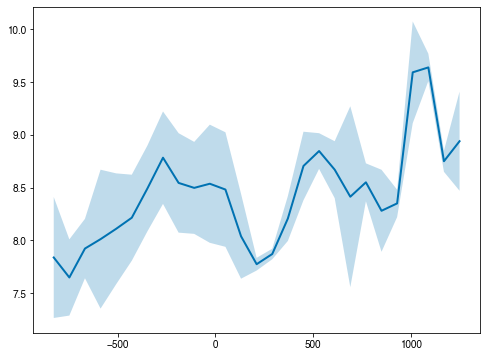

In [26]:
mpl.rc('font',family='Helvetica')

fig, ax = plt.subplots(figsize = (8,6))
x = jack4907_binned['yrAD']
y1 = jack4907_binned['upper']
y2 = jack4907_binned['lower']
# ax.plot('yrAD', 'd15n', data=df_jack4907, color = '#0072B2', linewidth = 0.5, alpha = 0.25, label = '')
ax.plot('yrAD', 'd15n', data=jack4907_binned, color='#0072B2', linewidth = 2, label = 'Jacksonville-4907-BC1 (continental slope)')
ax.fill_between(x, y1, y2, facecolor = '#0072B2', interpolate = True, alpha = 0.25)

In [23]:
print(df_jack4907.loc[df_jack4907['sample']==23]['yrAD'].values)
print(df_jack4907.loc[df_jack4907['sample']==56]['yrAD'].values)
print(df_jack4907.loc[df_jack4907['sample']==134]['yrAD'].values)

[626.]
[63.]
[-214.]


In [22]:
df_jack4907.loc[df_jack4907['sample']==23]['yrAD'].values

array([626.])